# Business Understanding
In the threat space for defense, there is a growing need to determine threats and provide a quick decisive counter measure.  The goal of this project is to determine what data provides the best threat fingerprint and deliver a model that can accurately determine that threat.
We will be using a generated dataset that will act as a RF threat dataset.  This basic dataset was generated with an industry experts guidance for the level of this course.  The reason for a stand-in dataset is that actual threat data is held classified and we will not be able to obtain that data.

The goal of this project is to approximate a model that can take in processed RF signal data and categorize a threat type.

The expectation of this project is that I will be able to build a model, with high accuracy, that can categorize synthetic threat data approximating a model that would be trained on real world data.

# Data Understanding
Here we will explore the dataset and get a sense of which features will give us the best categorization model.


In [ ]:
# Import all libraries needed for the study
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

c:\Users\neilh\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
# Generate the data
import data.CapstoneDataGenerator as cdg
cdg.generate_radar_dataset(num_samples=200000, output_path="data/radar_dataset_200k.zip")
df = pd.read_csv("data/radar_dataset_200k.zip", compression='zip')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Name         200000 non-null  object 
 1   Type         200000 non-null  object 
 2   Frequency    200000 non-null  float64
 3   Bandwidth    200000 non-null  float64
 4   Pulse Width  200000 non-null  float64
 5   Modulation   200000 non-null  object 
 6   Encoding     200000 non-null  object 
 7   PRI          200000 non-null  float64
 8   Amplitude    200000 non-null  float64
 9   Band         200000 non-null  object 
dtypes: float64(5), object(5)
memory usage: 15.3+ MB
None


In [3]:
# Determine if there are missing values
print(df.isna().sum())
print('Total missing cells ' + str(df.isna().sum().sum()))
print('Percentage of missing cells ' + str(df.isna().sum().sum()/df.size * 100))

Name           0
Type           0
Frequency      0
Bandwidth      0
Pulse Width    0
Modulation     0
Encoding       0
PRI            0
Amplitude      0
Band           0
dtype: int64
Total missing cells 0
Percentage of missing cells 0.0


We generated this data without any NaN or empty cells.  It's always good to check though.
Below we are doing a check to make sure that there aren't any radars that have very few datapoints.  Few data points would cause the model to not be able to categorize that radar well and could introduce errors.

In [4]:
# Look for any columns that have very few values
print("Name counts: " + str(df['Name'].value_counts()))
for col in df.columns:
    print(col + " number of unique values: " + str(len(df[col].value_counts())))

Name counts: Name
AEWWatch_01        8169
EWGuard_02         8126
MissileGuide_02    8126
AEWWatch_02        8122
AirScan_02         8120
EWGuard_03         8091
SARMapper_02       8068
CBRadar_01         8067
NavSeaScan_01      8044
TrackLock_02       8033
TrackLock_01       8028
EWGuard_01         8005
MissileGuide_03    8005
MissileGuide_01    7992
NavSeaScan_02      7980
FighterAESA_02     7979
GroundWatch_02     7960
SARMapper_01       7955
AirScan_01         7932
TrackLock_03       7920
FighterAESA_03     7908
FighterAESA_01     7864
CBRadar_02         7858
AirScan_03         7826
GroundWatch_01     7822
Name: count, dtype: int64
Name number of unique values: 25
Type number of unique values: 10
Frequency number of unique values: 200000
Bandwidth number of unique values: 200000
Pulse Width number of unique values: 200000
Modulation number of unique values: 3
Encoding number of unique values: 6
PRI number of unique values: 200000
Amplitude number of unique values: 200000
Band numbe

We can see that we have a pretty even spread of each unique radar.  We won't run into any issues of low sample sizes.

# Data Preparation
Here we are going to start the data preparations.  First, we will transform the data to view the cross correlation table.

In [5]:
def LabelEncodeCol(dataframe : pd.DataFrame, col : str):
    print(dataframe[col].value_counts().index.to_list())
    le = LabelEncoder().fit(dataframe[col].value_counts().index.to_list())
    dataframe[col] = le.transform(dataframe[col])
    print(dataframe[col].value_counts().index.to_list())


LabelEncodeCol(df, 'Modulation')
LabelEncodeCol(df, 'Encoding')
LabelEncodeCol(df, 'Band')
LabelEncodeCol(df, 'Name')
LabelEncodeCol(df, 'Type')
df.corr() # This is non-normalized

['FM', 'PM', 'AM']
[1, 2, 0]
['Linear FM (chirp)', 'Phase-coded', 'Unmodulated pulse', 'Barker code', 'Polyphase code', 'Unmodulated CW pulse']
[1, 2, 5, 0, 3, 4]
['X', 'S', 'Ku', 'L', 'Ka', 'C']
[5, 4, 2, 3, 1, 0]
['AEWWatch_01', 'EWGuard_02', 'MissileGuide_02', 'AEWWatch_02', 'AirScan_02', 'EWGuard_03', 'SARMapper_02', 'CBRadar_01', 'NavSeaScan_01', 'TrackLock_02', 'TrackLock_01', 'EWGuard_01', 'MissileGuide_03', 'MissileGuide_01', 'NavSeaScan_02', 'FighterAESA_02', 'GroundWatch_02', 'SARMapper_01', 'AirScan_01', 'TrackLock_03', 'FighterAESA_03', 'FighterAESA_01', 'CBRadar_02', 'AirScan_03', 'GroundWatch_01']
[0, 8, 16, 1, 3, 9, 21, 5, 18, 23, 22, 7, 17, 15, 19, 11, 14, 20, 2, 24, 12, 10, 6, 4, 13]
['Early-warning', 'Missile guidance / illumination', 'Tracking / fire-control', 'Air-surveillance', 'Fighter multi-mode', 'Airborne early-warning', 'Naval surface-search', 'SAR / imaging', 'Counter-battery', 'Ground-surveillance']
[3, 6, 9, 0, 4, 1, 7, 8, 2, 5]


,Name,Type,Frequency,Bandwidth,Pulse Width,Modulation,Encoding,PRI,Amplitude,Band
Name,1.000000,0.983160,0.664668,0.317041,-0.276386,-0.006317,-0.014928,-0.543591,-0.000629,-0.056734
Type,0.983160,1.000000,0.640118,0.330199,-0.276685,0.002590,-0.000314,-0.469348,-0.000383,-0.042574
Frequency,0.664668,0.640118,1.000000,0.703901,-0.392983,0.252336,-0.126901,-0.499301,-0.004953,-0.308957
Bandwidth,0.317041,0.330199,0.703901,1.000000,-0.111265,0.271537,-0.164103,-0.062313,-0.003768,-0.124642
Pulse Width,-0.276386,-0.276685,-0.392983,-0.111265,1.000000,-0.096682,-0.294538,0.375236,0.001424,-0.034496
Modulation,-0.006317,0.002590,0.252336,0.271537,-0.096682,1.000000,-0.504181,-0.079983,0.000185,-0.331312
Encoding,-0.014928,-0.000314,-0.126901,-0.164103,-0.294538,-0.504181,1.000000,0.029514,-0.000765,0.086691
PRI,-0.543591,-0.469348,-0.499301,-0.062313,0.375236,-0.079983,0.029514,1.000000,0.000273,-0.054110
Amplitude,-0.000629,-0.000383,-0.004953,-0.003768,0.001424,0.000185,-0.000765,0.000273,1.000000,0.004587
Band,-0.056734,-0.042574,-0.308957,-0.124642,-0.034496,-0.331312,0.086691,-0.054110,0.004587,1.000000


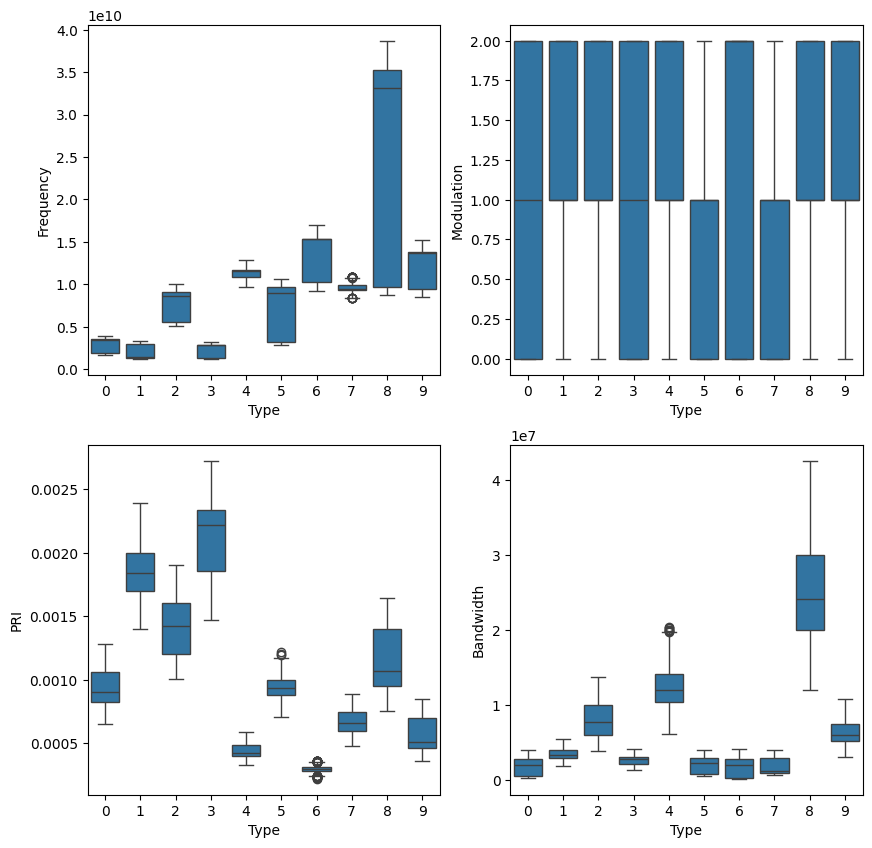

In [6]:
fit, axes = plt.subplots(2,2,figsize=(10,10))
sns.boxplot(data=df, x='Type', y='Frequency', ax=axes[0,0])
sns.boxplot(data=df, x='Type', y='PRI', ax=axes[1,0])
sns.boxplot(data=df, x='Type', y='Modulation', ax=axes[0,1])
sns.boxplot(data=df, x='Type', y='Bandwidth', ax=axes[1,1])

plt.show()

Here we are going to scale the numeric data and get our train and test splits.  I want to see how each model predicts a type of radar vs. the specific radar (Name).

In [7]:
scaler = StandardScaler()

X = df.drop(['Type', 'Name'], axis=1)
X_scaled = scaler.fit_transform(X)
y_t = df['Type']
y_name = df['Name']


X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y_t, test_size=0.2)
X_train_name, X_test_name, y_train_name, y_test_name = train_test_split(X, y_name, test_size=0.2)

# Modeling

Make a baseline model to compare to our final model.

### Baseline 'Dummy' Classifier

Radar Type Score: 0.118025
Specific Radar Score: 0.041025


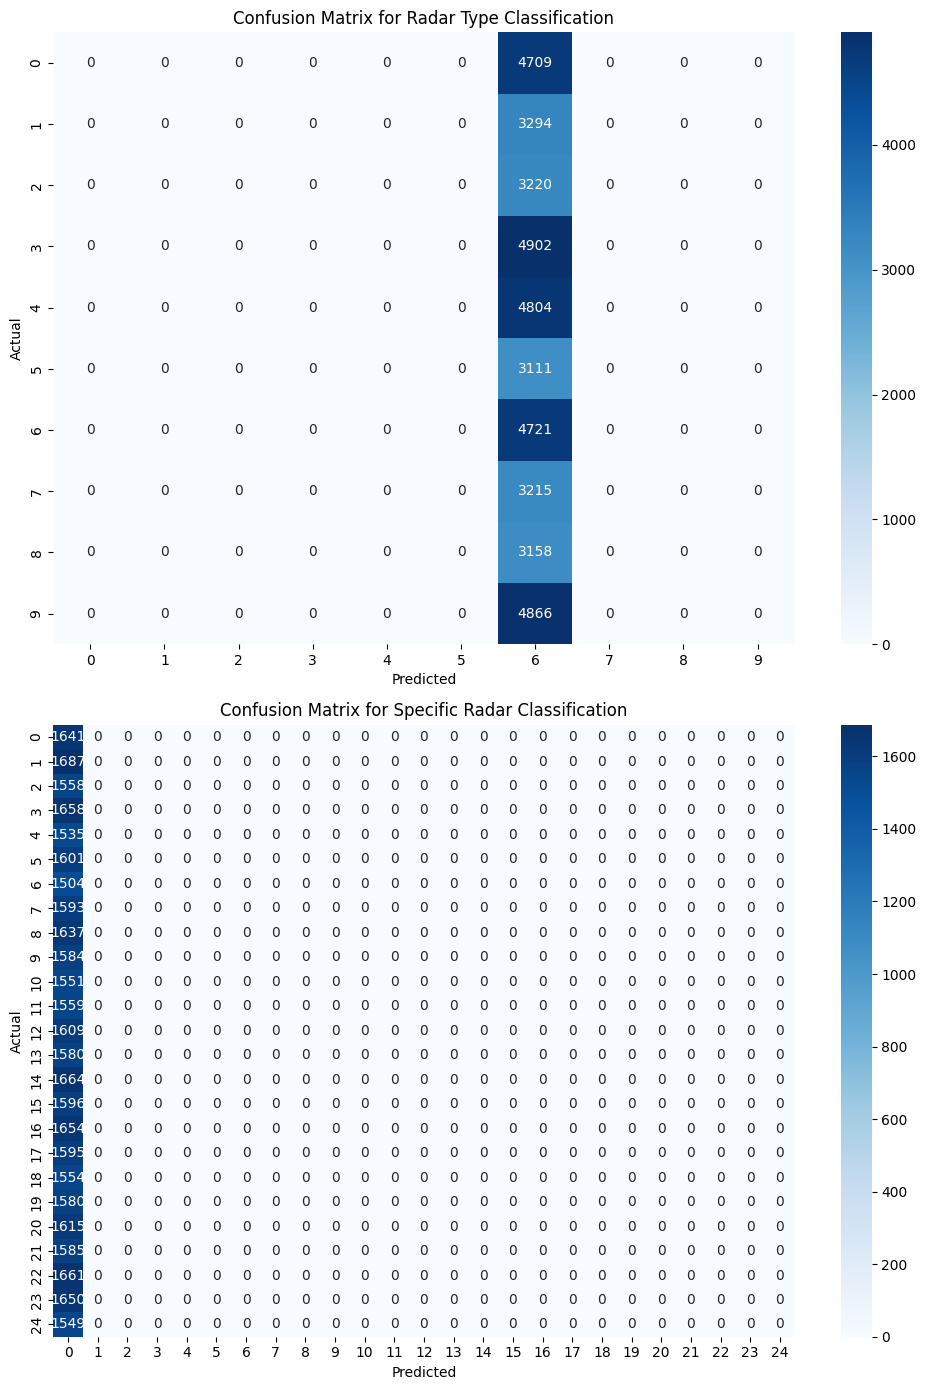

In [8]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', DummyClassifier())
])
pipe.fit(X_train_t, y_train_t)
print("Radar Type Score: " + str(pipe.score(X_test_t, y_test_t)))

# Generate predictions for confusion matrices
y_pred_t = pipe.predict(X_test_t)
cm_t = confusion_matrix(y_test_t, y_pred_t)

pipe.fit(X_train_name, y_train_name)
print("Specific Radar Score: " + str(pipe.score(X_test_name, y_test_name)))

y_pred_name = pipe.predict(X_test_name)
cm_name = confusion_matrix(y_test_name, y_pred_name)

# Create a figure with 2 subplots for confusion matrices
fig, axes = plt.subplots(2, 1, figsize=(10, 14))

# First subplot: Radar Type Classification confusion matrix
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Radar Type Classification')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Second subplot: Specific Radar Classification confusion matrix
sns.heatmap(cm_name, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Specific Radar Classification')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Now that we have a baseline model we can start to take a look at some other models to compare our performance.

### Logistic Regression

In [11]:
# Set up the Logistic Regression parameter grid
param_grid = {
    'lr__C': [0.01, 0.1, 1],
    'lr__fit_intercept': [True, False],
    'lr__max_iter': [100, 200, 500]
}

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Radar Type Score: 0.99535
Best Parameters for Radar Type Classification: {'lr__C': 1, 'lr__fit_intercept': True, 'lr__max_iter': 100}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Specific Radar Score: 0.99065
Best Parameters for Specific Radar Classification: {'lr__C': 1, 'lr__fit_intercept': True, 'lr__max_iter': 200}


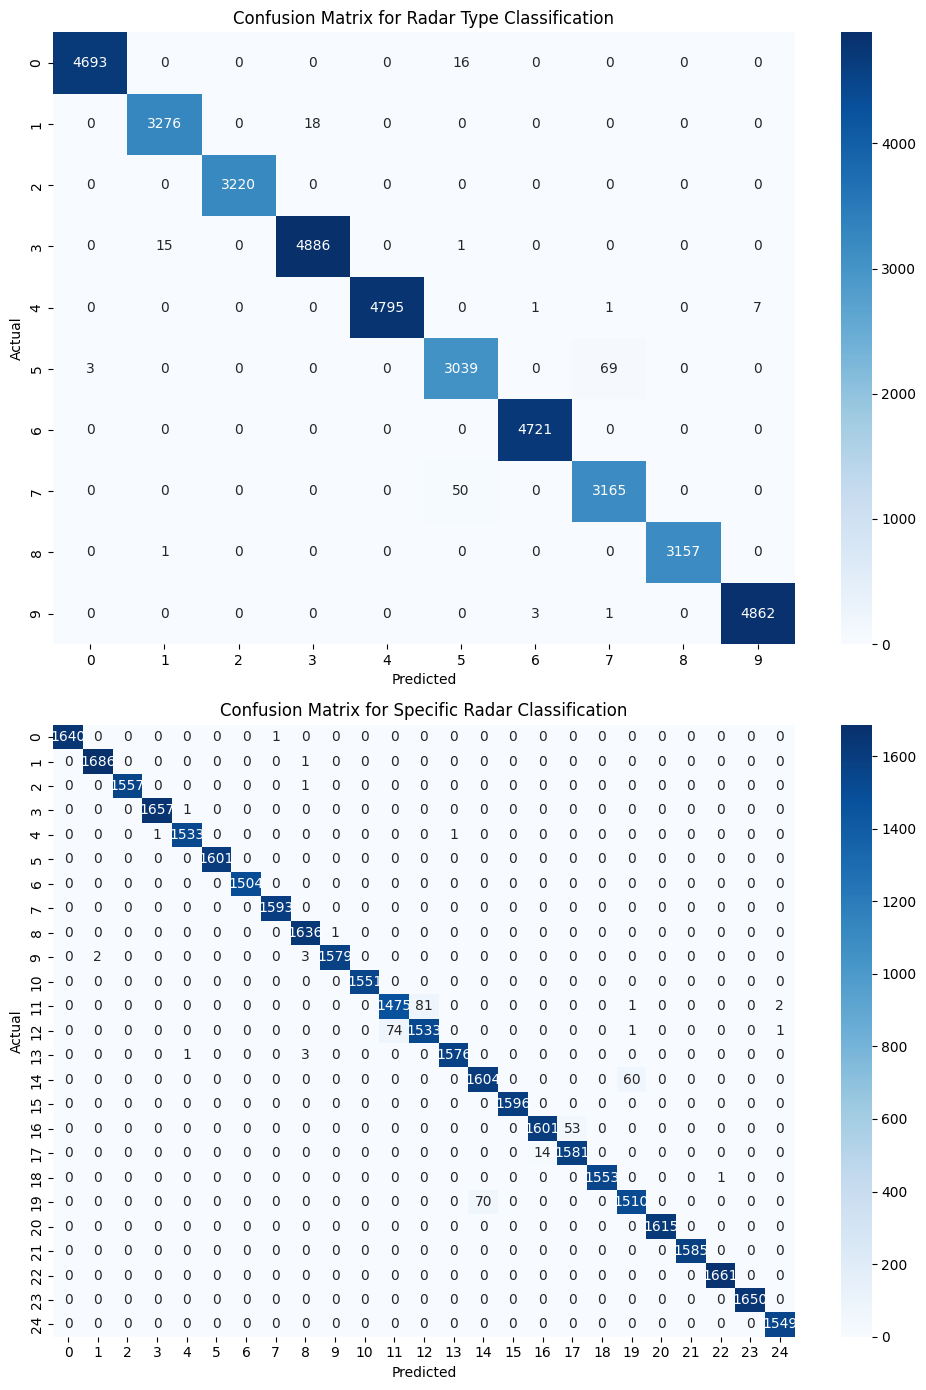

In [12]:
# Setup the pipeline with Logistic Regression
pipe_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000))
])

grid = GridSearchCV(pipe_reg, param_grid, cv=5, n_jobs=-1, verbose=1)

grid.fit(X_train_t, y_train_t)
print("Radar Type Score: " + str(grid.best_estimator_.score(X_test_t, y_test_t)))
print("Best Parameters for Radar Type Classification: " + str(grid.best_params_))

# Generate predictions for confusion matrices
y_pred_t = grid.best_estimator_.predict(X_test_t)
cm_t = confusion_matrix(y_test_t, y_pred_t)

grid.fit(X_train_name, y_train_name)
print("Specific Radar Score: " + str(grid.best_estimator_.score(X_test_name, y_test_name)))
print("Best Parameters for Specific Radar Classification: " + str(grid.best_params_))

y_pred_name = grid.best_estimator_.predict(X_test_name)
cm_name = confusion_matrix(y_test_name, y_pred_name)

# Create a figure with 2 subplots for confusion matrices
fig, axes = plt.subplots(2, 1, figsize=(10, 14))

# First subplot: Radar Type Classification confusion matrix
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Radar Type Classification')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Second subplot: Specific Radar Classification confusion matrix
sns.heatmap(cm_name, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Specific Radar Classification')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### Decision Tree Classifier

In [13]:
# Create the parameter grid for Decision Tree
param_grid = {
    'dt__max_depth': [5, 10, 20, None],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Radar Type Score: 0.999125
Best Parameters for Radar Type Classification: {'dt__max_depth': 20, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 5}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Specific Radar Score: 0.997975
Best Parameters for Specific Radar Classification: {'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}


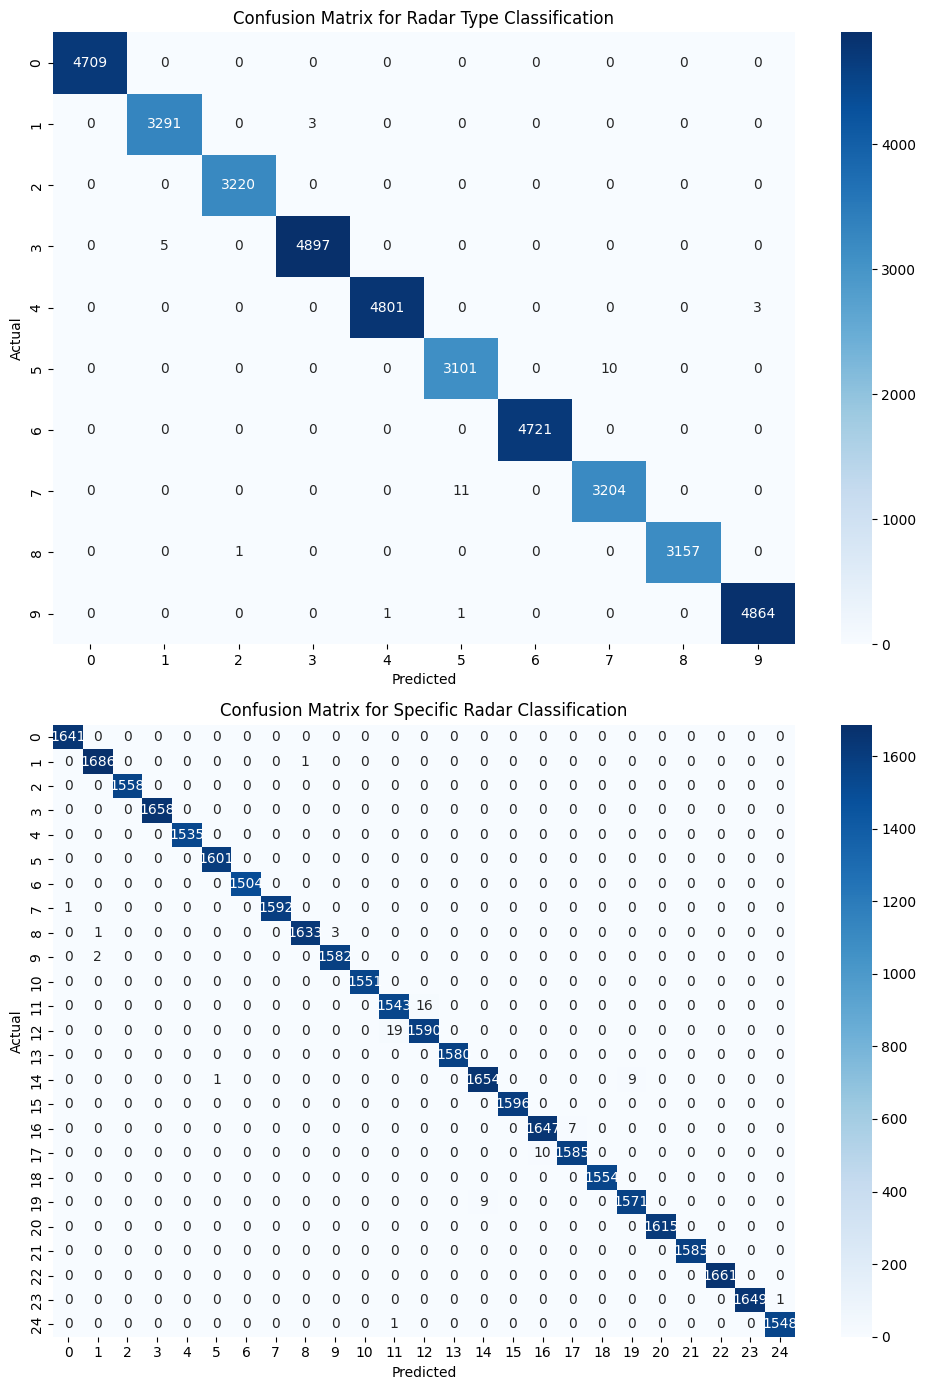

In [14]:
pipe_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier())
])

grid = GridSearchCV(pipe_tree, param_grid, cv=5, n_jobs=-1, verbose=1)

grid.fit(X_train_t, y_train_t)
print("Radar Type Score: " + str(grid.best_estimator_.score(X_test_t, y_test_t)))
print("Best Parameters for Radar Type Classification: " + str(grid.best_params_))

# Generate predictions for confusion matrices
y_pred_t = grid.best_estimator_.predict(X_test_t)
cm_t = confusion_matrix(y_test_t, y_pred_t)

grid.fit(X_train_name, y_train_name)
print("Specific Radar Score: " + str(grid.best_estimator_.score(X_test_name, y_test_name)))
print("Best Parameters for Specific Radar Classification: " + str(grid.best_params_))

y_pred_name = grid.best_estimator_.predict(X_test_name)
cm_name = confusion_matrix(y_test_name, y_pred_name)

# Create a figure with 2 subplots for confusion matrices
fig, axes = plt.subplots(2, 1, figsize=(10, 14))

# First subplot: Radar Type Classification confusion matrix
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Radar Type Classification')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Second subplot: Specific Radar Classification confusion matrix
sns.heatmap(cm_name, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Specific Radar Classification')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

The decision tree classifier performed slightly better than the logistic regression.  Let's try a boosting model with a decision tree classifier as the base model.

### Boosted Decision Tree Classifier

In [23]:
# Parameter grid for Boosted Decision Tree
param_grid = {
    'dt__estimator__max_depth': [3, 5, 10],
    'dt__estimator__min_samples_split': [2, 5, 10],
    'dt__estimator__min_samples_leaf': [1, 2, 4],
    'dt__n_estimators': [50, 100, 200],
    'dt__learning_rate': [0.01, 0.1]
}

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Radar Type Score: 0.9995
Best Parameters for Radar Type Classification: {'dt__estimator__max_depth': 5, 'dt__estimator__min_samples_leaf': 4, 'dt__estimator__min_samples_split': 2, 'dt__learning_rate': 0.1, 'dt__n_estimators': 100}
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Specific Radar Score: 0.999175
Best Parameters for Specific Radar Classification: {'dt__estimator__max_depth': 5, 'dt__estimator__min_samples_leaf': 4, 'dt__estimator__min_samples_split': 5, 'dt__learning_rate': 0.1, 'dt__n_estimators': 200}


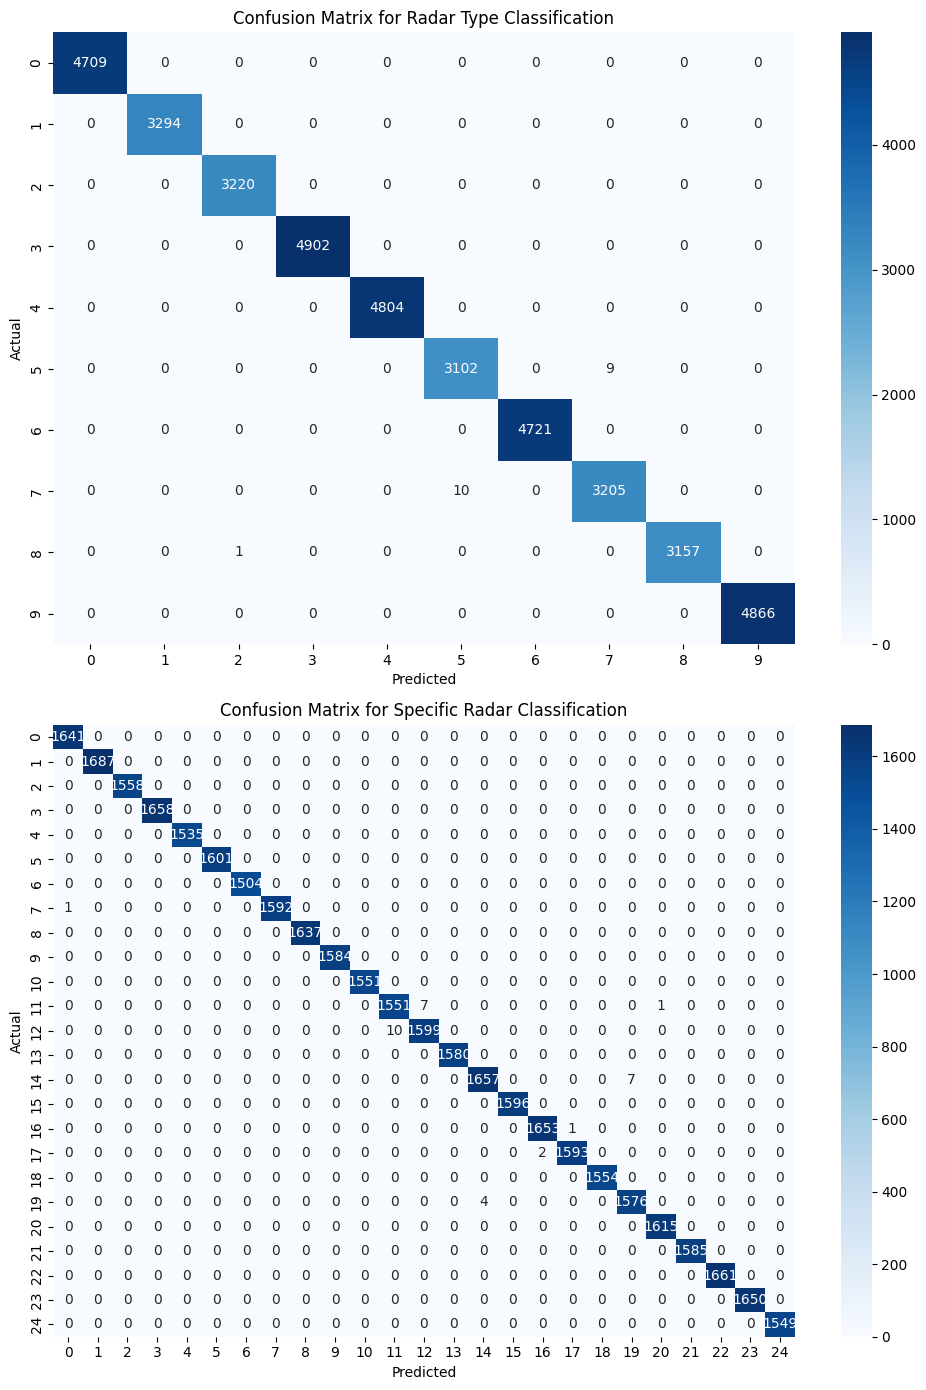

In [24]:
pipe_boost = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=1000))
])

grid = GridSearchCV(pipe_boost, param_grid, cv=5, n_jobs=-1, verbose=1)

grid.fit(X_train_t, y_train_t)
print("Radar Type Score: " + str(grid.best_estimator_.score(X_test_t, y_test_t)))
print("Best Parameters for Radar Type Classification: " + str(grid.best_params_))

# Generate predictions for confusion matrices
y_pred_t = grid.best_estimator_.predict(X_test_t)
cm_t = confusion_matrix(y_test_t, y_pred_t)

grid.fit(X_train_name, y_train_name)
print("Specific Radar Score: " + str(grid.best_estimator_.score(X_test_name, y_test_name)))
print("Best Parameters for Specific Radar Classification: " + str(grid.best_params_))

y_pred_name = grid.best_estimator_.predict(X_test_name)
cm_name = confusion_matrix(y_test_name, y_pred_name)

# Create a figure with 2 subplots for confusion matrices
fig, axes = plt.subplots(2, 1, figsize=(10, 14))

# First subplot: Radar Type Classification confusion matrix
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Radar Type Classification')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Second subplot: Specific Radar Classification confusion matrix
sns.heatmap(cm_name, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Specific Radar Classification')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

The boosting helped a bit for the decision tree classifier accuracy.  Let's try one last model before moving on to evaluation.

### Random Forest Classifier

In [25]:
# Parameter grid for the Random Forest Classifier
param_grid = {
    'forest__n_estimators': [100, 200, 500],
    'forest__max_depth': [None, 10, 20, 40],
    'forest__min_samples_split': [2, 5, 10],
    'forest__min_samples_leaf': [1, 2, 3],
}

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Radar Type Score: 0.9995
Best Parameters for Radar Type Classification: {'forest__max_depth': 40, 'forest__min_samples_leaf': 1, 'forest__min_samples_split': 5, 'forest__n_estimators': 100}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Specific Radar Score: 0.9991
Best Parameters for Specific Radar Classification: {'forest__max_depth': None, 'forest__min_samples_leaf': 1, 'forest__min_samples_split': 2, 'forest__n_estimators': 500}


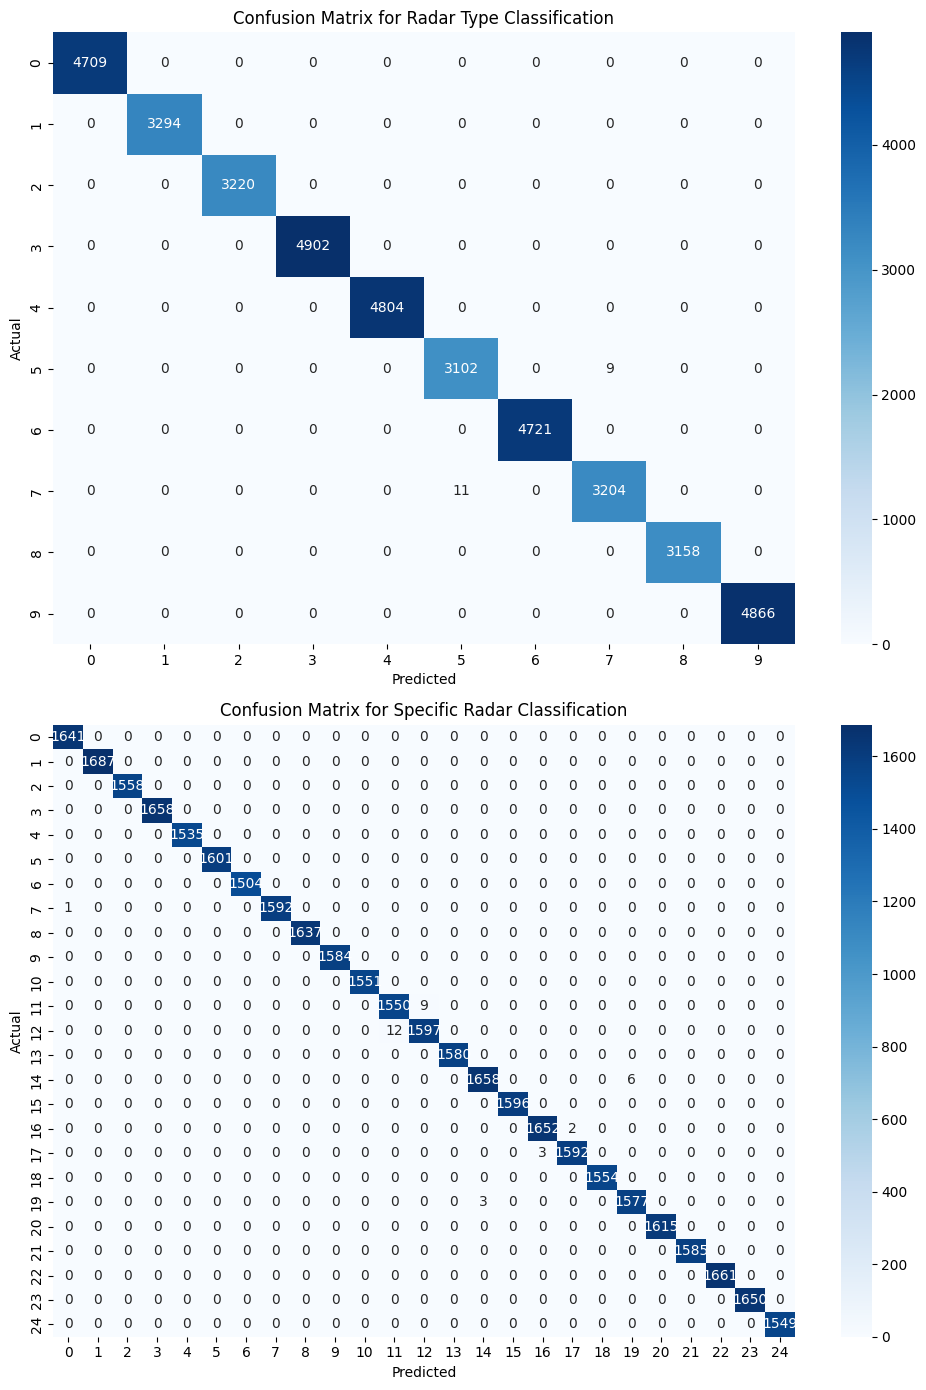

In [26]:
pipe_forest = Pipeline([
    ('scaler', StandardScaler()),
    ('forest', RandomForestClassifier())
])

grid = GridSearchCV(pipe_forest, param_grid, cv=5, n_jobs=-1, verbose=1)

grid.fit(X_train_t, y_train_t)
print("Radar Type Score: " + str(grid.best_estimator_.score(X_test_t, y_test_t)))
print("Best Parameters for Radar Type Classification: " + str(grid.best_params_))

# Generate predictions for confusion matrices
y_pred_t = grid.best_estimator_.predict(X_test_t)
cm_t = confusion_matrix(y_test_t, y_pred_t)

grid.fit(X_train_name, y_train_name)
print("Specific Radar Score: " + str(grid.best_estimator_.score(X_test_name, y_test_name)))
print("Best Parameters for Specific Radar Classification: " + str(grid.best_params_))

y_pred_name = grid.best_estimator_.predict(X_test_name)
cm_name = confusion_matrix(y_test_name, y_pred_name)

# Create a figure with 2 subplots for confusion matrices
fig, axes = plt.subplots(2, 1, figsize=(10, 14))

# First subplot: Radar Type Classification confusion matrix
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Radar Type Classification')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Second subplot: Specific Radar Classification confusion matrix
sns.heatmap(cm_name, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Specific Radar Classification')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

As we can see, some of the models are quite successful in categorizing the individual radar types.  This is encouraging.  I'd like to move forward with a RandomForestClassifier for evaluation and deployment.  It performed about the same as the boosted decision tree.  It had much faster training times though.
The models provided very high accuracy scores.  However, I fully expect that real-world data will have many more radar types and there will be much more overlap of each feature causing some additional errors.  The feature set is mostly complete, but there will be additional features extracted in a real world scenario.

Let's move on to Evaluation of the RandomForestClassifier.  This evaulation can be found in [Capstone_Evaluation.ipynb](Capstone_Evaluation.ipynb)